Camera calibration using chessboard images

True

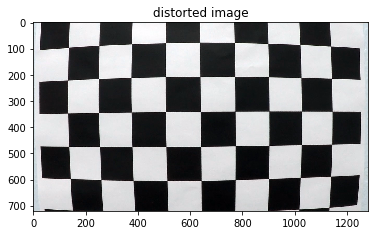

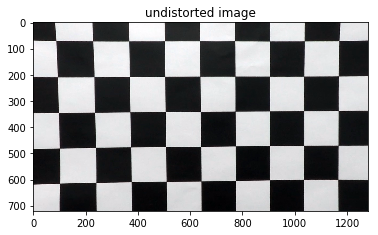

In [117]:
counter = 0
gen_images = False

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None)     

# read and undistort a test image
img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure()
plt.title('distorted image')
plt.imshow(img)
cv2.imwrite('test_images/distorted.jpg', img)


plt.figure()
plt.title('undistorted image')
plt.imshow(dst)
cv2.imwrite('test_images/undistorted.jpg', dst)


In [112]:
def warp_image(img):
    global counter
    global gen_images
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    if gen_images:
        im = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR)                
        cv2.imwrite('./images/' + 'before_wrap' + str(counter) + '.png', im)
        im = cv2.cvtColor(warped.astype(np.uint8), cv2.COLOR_RGB2BGR)        
        cv2.imwrite('./images/' + 'wraped' + str(counter) + '.png', im)
    
    return warped

def unwarp_image(img):
    global counter
    global gen_images
    
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
    
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    if gen_images:
        im = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR)        
        
        cv2.imwrite('./images/' + 'before_unwrap' + str(counter) + '.png', im)
        im = cv2.cvtColor(unwarped.astype(np.uint8), cv2.COLOR_RGB2BGR)        
        
        cv2.imwrite('./images/' + 'unwraped' + str(counter) + '.png', im)

    return unwarped

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [103]:
def color_and_gradient_pipeline(img, s_thresh=(200, 255), thresh = (0.7, 1.3), sx_thresh=(10, 255), sy_thresh=(10, 255)):
    
    #apply gussian blurring 
    blur = cv2.GaussianBlur(img,(5,5),0)
    
    # Convert to HSV color space for color mask
    hsv = cv2.cvtColor(blur, cv2.COLOR_RGB2HSV).astype(np.float)
    
    yellow_hsv_low  = np.array([ 0, 70, 80])
    yellow_hsv_high = np.array([ 70, 255, 255])
    
    mask_yellow = cv2.inRange(hsv, yellow_hsv_low, yellow_hsv_high)

    white_hsv_low  = np.array([  0,   0,   165])
    white_hsv_high = np.array([ 200,  100, 255])

    mask_white = cv2.inRange(hsv, white_hsv_low, white_hsv_high)
    
    # Combine white and yellow masks
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white) 

    if gen_images:
        cv2.imwrite('./images/' + 'mask' + str(counter) + '.png', mask_lane)
        
    #plt.figure()
    #plt.imshow(mask_lane)

    # Convert to HSL color space and separate the S and L channels
    hls = cv2.cvtColor(blur, cv2.COLOR_RGB2HLS).astype(np.float)

    h_channel = hls[:,:,0]    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=15) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(l_channel)
    sxbinary[(scaled_sobelx > sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=15) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    sybinary = np.zeros_like(l_channel)
    sybinary[(scaled_sobely > sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    

    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    drbinary =  np.zeros_like(absgraddir)
    drbinary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Stack each channel
    final_binary = np.zeros_like(drbinary)
    final_binary[((sybinary >= 0.5) | (sxbinary == 1) ) & (mask_lane >= 0.5)] = 1
    
    color_binary = np.dstack((np.zeros_like(absgraddir), np.zeros_like(absgraddir), 255*final_binary))
    if gen_images:
        cv2.imwrite('./images/' + 'gradient' + str(counter) + '.png', color_binary)    
    #plt.figure()
    #plt.imshow(color_binary)

    return final_binary

In [138]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def calc_curvature(img, ploty, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/abs(rightx[-1] - leftx[-1]) # meters per pixel in x dimension

    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate car position offset
    lane_center_x = leftx[-1] + (rightx[-1] - leftx[-1])/2
    image_center_x = img.shape[1]/2
    
    return left_curverad, right_curverad, (image_center_x - lane_center_x) * xm_per_pix

def find_lanes(binary_warped):
    global counter
    global gen_images
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    if gen_images:
        fig = plt.figure()
        plt.plot(histogram) 
        plt.title("Histogram of animage") 
        plt.savefig('images/data_hist' + str(counter) + '.png', bbox_inches='tight')    
        plt.close(fig)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((np.zeros_like(binary_warped), np.zeros_like(binary_warped), np.zeros_like(binary_warped)))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if len(rightx) > 0 and len(righty) > 0 and len(leftx) > 0 and len(lefty) > 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        return left_fit, right_fit, out_img

    return None, None, out_img

def draw_lanes(left_fit, right_fit, binary_warped, out_img):
    global counter
    global gen_images
        
    # Set the width of the windows +/- margin
    margin = 100
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    window_img = np.dstack((np.zeros_like(binary_warped), np.zeros_like(binary_warped), np.zeros_like(binary_warped)))

    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    left_line_points = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

    line_pts = np.hstack((left_line_points, right_line_points))
    
    # Draw the lane onto the warped blank image
    cv2.polylines(window_img, np.int_([left_line_points]), False, (255, 0, 0), 30)
    cv2.polylines(window_img, np.int_([right_line_points]), False, (0, 0, 255), 30)

    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))

    if gen_images:
        if out_img is not None:
            cv2.polylines(out_img, np.int_([left_line_points]), False, (255, 0, 0), 30)
            cv2.polylines(out_img, np.int_([right_line_points]), False, (0, 0, 255), 30)            
            cv2.imwrite('./images/find_lanes' + str(counter) + '.png', out_img)

    # Calculate and render curvature numbers
    left_curv, right_curv, car_pos = calc_curvature(window_img, ploty, left_fitx, right_fitx)
    
    result = cv2.addWeighted(out_img, 0.0, window_img, 1.0, 0)
    
    curv = "Curv: {0:.2f}m".format((left_curv + right_curv)/2)
    car_offset = "Car Position: {0:.2f}m".format(car_pos)

    return result, curv, car_offset

In [99]:
left_lane = None
right_lane = None


def find_lanes_pipeline(img):
    global counter
    global gen_images
    global left_lane
    global right_lane
    
    # Undistort image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    #Wrap image by running a perspective transform
    warped_img = warp_image(img)
    
    #build and apply gradient and color tresholds 
    gradient_img = color_and_gradient_pipeline(warped_img)
    
    # find lanes
    left_fit, right_fit, out_img = find_lanes(gradient_img)

    #apply lanes to a current ones by smoothing
    #the addition lanes = 0.9*lanes + 0.1*new_lanes
    if left_lane is None:
        left_lane = left_fit
        right_lane = right_fit
    else:
        # compute the area for current and newly found lanes
        # if deviation betweein the areas is too big ignore 
        # new lanes, that is likely an indication of some picked
        # artifacts in algorithm
        contour1 = np.concatenate((left_lane.astype(np.float), right_lane.astype(np.float)))
        contour1 = contour1.reshape((-1,1,2)).astype(np.int32)        
        cntArea1 = cv2.contourArea(contour1)
        if left_fit is not None and right_fit is not None:
            contour2 =  np.concatenate((left_fit.astype(np.float), right_fit.astype(np.float)))
            contour2 = contour2.reshape((-1,1,2)).astype(np.int32)        
            cntArea2 = cv2.contourArea(contour2)
            if abs(cntArea2 - cntArea1) < 200000:
                left_lane = 0.9 * left_lane + 0.1 * left_fit
                right_lane = 0.9 * right_lane + 0.1 * right_fit
            
    # draw lanes and return lane curvature and car position off the camera center
    found_lanes_img, curverad, car_offset = draw_lanes(left_lane, right_lane, gradient_img, out_img)
    unwarped_img = unwarp_image(found_lanes_img)

    # Now our radius of curvature is in meters
    cv2.putText(img, curverad, (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.putText(img, car_offset, (40, 140), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    
    result = cv2.addWeighted(unwarped_img.astype(np.uint8), 0.5, img, 1, 0)
    if gen_images:
        im = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        cv2.imwrite('./images/result' + str(counter) + '.png', im)
    counter = counter + 1
    
    return result

In [139]:
#### Import everything needed to edit/save/watch video clips
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

counter = 0

def process_image(image):
    return find_lanes_pipeline(image)

output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
videos = glob.glob('./project_video.mp4')

# Step through the list and search for chessboard corners
for video in videos:
    output = 'test_videos_output/' + video
    clip = VideoFileClip(video)
    #.subclip(0,10)
    if not os.path.exists('test_videos_output'):
        os.makedirs('test_videos_output')
    lane_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
    %time lane_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/./challenge_video.mp4
[MoviePy] Writing video test_videos_output/./challenge_video.mp4



 32%|███▏      | 155/485 [00:34<01:08,  4.84it/s]


 64%|██████▎   | 309/485 [01:09<00:37,  4.67it/s]


 95%|█████████▌| 463/485 [01:42<00:04,  4.51it/s]


100%|██████████| 485/485 [01:47<00:00,  4.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/./challenge_video.mp4 

CPU times: user 1min 59s, sys: 8.76 s, total: 2min 8s
Wall time: 1min 48s
